In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import os
import csv

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, cross_val_predict
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.gridspec as gridspec

from deforestutils import *

from joblib import dump, load
from joblib import Parallel, delayed




/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode

In [ ]:


#what to visualize after getting results: 
# mse for each model by year
# important features by year 


In [ ]:
first_time = True

for this_start_year in tqdm([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]):
    SUBSET = False
    SUBSET_SIZE = 10000

    if first_time: 
        NEW_INDICES = True
        NEW_CV_INDICES = True
        #first_time = False
        print('Set to create new indices for test train split and cross validation')
    else: 
        NEW_INDICES = False
        NEW_CV_INDICES = False
        print('Reading previous iteration test train split indices and cross validation indices')
    

    PLOT_ENTIRE_AREA = True
    PLOT_FOLDS = False

    START_YEAR_TRAIN = this_start_year
    NUMBER_YEARS_TRAIN = 3
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + i  for i in range(NUMBER_YEARS_TRAIN + 1)]

    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN

    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + i}_' for i in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'

    FILE_PATH = f'FeatureImportanceResults/{FOLDER_NAME}/'

    print(f'Starting fit for {this_start_year}')

    setup_directory(FOLDER_NAME)
    
    df_full = get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN)
    
    if SUBSET:
        df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)

    X, Y = split_XY(df_full)

    if NEW_INDICES:
        train_inds, test_inds = get_new_test_train_inds(X, Y, df_full, FOLDER_NAME)
    if not NEW_INDICES:
        train_inds, test_inds = get_prev_test_train_inds(FOLDER_NAME)

    X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME)

    if NEW_CV_INDICES:
        muni_cv = get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR, FILE_PATH)
    if not NEW_CV_INDICES:
        muni_cv = get_prev_cv(FOLDER_NAME)

    #get_null_count(X_train, FOLDER_NAME)
            
    #X_train = X_train.drop('geometry', axis = 1)
    #X_test = X_test.drop('geometry', axis = 1)

    #random forest
    #randomforest_features_df = train_random_forest(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #lasso 
    #lasso_features_df = train_lasso(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #gradient boosting
    #gradient_boosting_features_df = train_gradient_boost(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)
    
    #neural network
    #nn_features_df = train_neural_network(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #super learner ensemble
    #base_learners = get_base_learners(FOLDER_NAME)
    #super_learner_features_df = train_super_learner(X_train, Y_train, X_test, Y_test, FILE_PATH, muni_cv, base_learners, FOLDER_NAME)

    #visualize
    yhat_list = get_yhat_list(FOLDER_NAME)
    visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)
    visualize_predictions_single_plot(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)

    for method in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner']:
        plot_feature_importance(FILE_PATH, FOLDER_NAME, method, use_abs = True)
        plot_feature_importance(FILE_PATH, FOLDER_NAME, method, SHOW = False, INCLUDE_FOREST = False, use_abs = True)
    

In [ ]:
def plot_feature_importance_all_methods(X_train, FILE_PATH, FOLDER_NAME, method, SHOW = True, INCLUDE_FOREST = True, use_abs = True):
    
    
    base_df = pd.DataFrame(X_train.columns)
    base_df.columns = ['Feature']

    for method in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner']:
        file_path = FILE_PATH + 'FeatureImportance/' + method + '.csv'
        df = pd.read_csv(file_path, index_col=0)
    

    if not INCLUDE_FOREST:
        df = df[~df.Feature.isin(['forest_lag', 'forest_formation'])]
        file_path_save = FILE_PATH + 'FeatureImportance/' + 'features_exclude_forest_vars_' + method

    abs_sum = df['Coeff'].abs().sum()
    df['Coeff'] = df['Coeff'] / abs_sum

    coeff_values = df['Coeff'].head(10)
    feature_labels = df['Feature'].head(10)

    if abs:
        coeff_values = (abs(coeff_values))

    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coeff_values, y=feature_labels, color='green')

    # Set plot title and labels
    plt.title(FOLDER_NAME + ' ' + method.upper() )
    #plt.xlabel('Abs')
    #plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(file_path_save)
    if SHOW: plt.show()

ValueError: 'right' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'

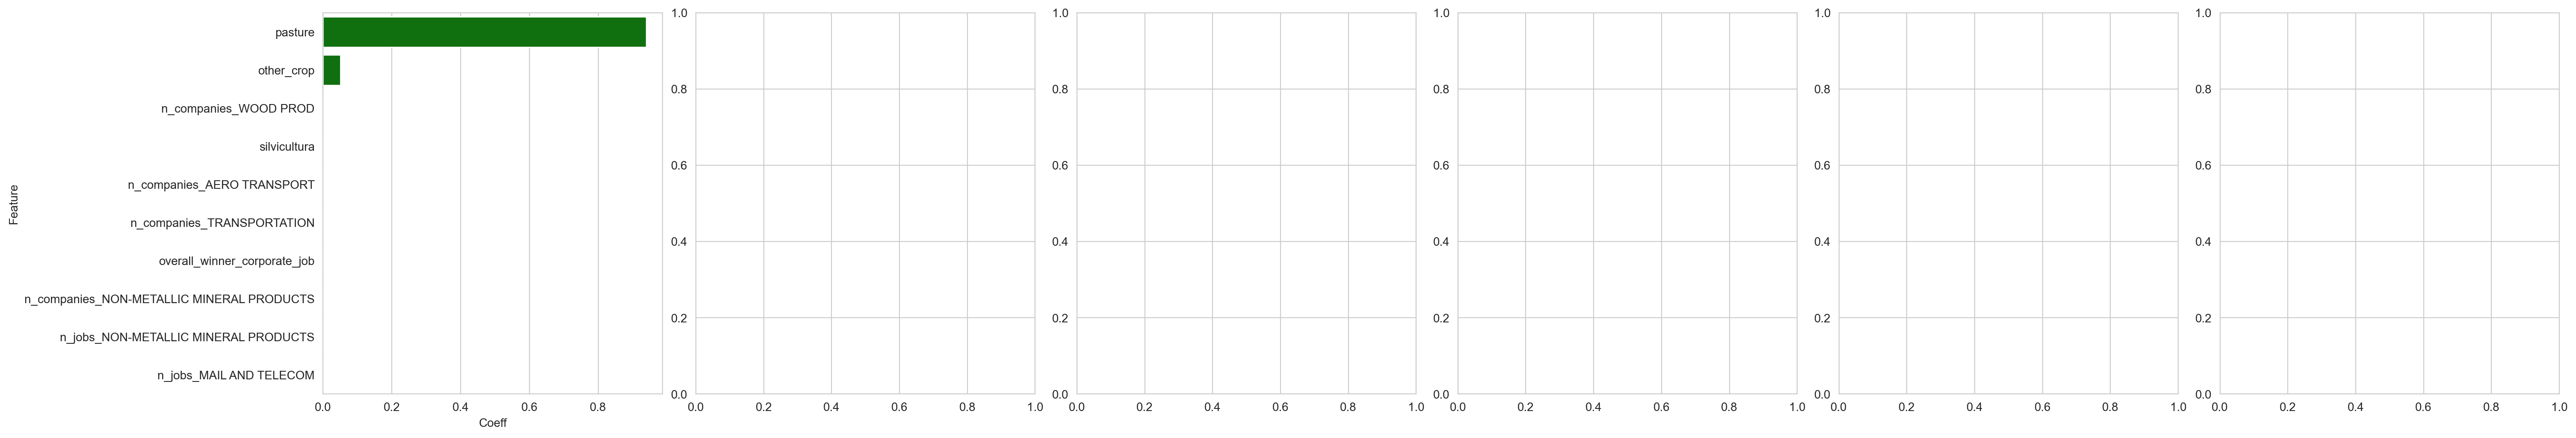

In [119]:
INCLUDE_FOREST = False
base_df = pd.DataFrame(X_train.columns)
base_df.columns = ['Feature']

for method in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner']:
    file_path = FILE_PATH + 'FeatureImportance/' + method + '.csv'
    df = pd.read_csv(file_path, index_col=0)
    df.columns = ['Feature', method]
    base_df = pd.merge(base_df, df, how = 'left', on = 'Feature')

base_df['avg'] = base_df.drop('Feature', axis=1).mean(axis=1)

sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 6, figsize=(30, 5), layout="constrained", dpi=200) 

for i, col_name in enumerate(['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner', 'avg']):
    subset_df = base_df[['Feature', col_name]]
    subset_df.columns = ['Feature', 'Coeff']

    if not INCLUDE_FOREST:
        subset_df = subset_df[~subset_df.Feature.isin(['forest_lag', 'forest_formation'])]

    abs_sum = subset_df['Coeff'].abs().sum()
    subset_df['Coeff'] = subset_df['Coeff'] / abs_sum
    subset_df = subset_df.sort_values(by='Coeff', ascending = False)

    coeff_values = subset_df['Coeff'].head(10)
    feature_labels = subset_df['Feature'].head(10)

    if abs: coeff_values = (abs(coeff_values))

    sns.barplot(x=coeff_values, y=feature_labels, color='green', ax=axs[i])

    for patch in axs[i].patches:
        width = patch.get_width()
        axs[i].annotate(f'{width:.2f}', (width/2, patch.get_y()+0.5), ha='center', va='right')

    # Hide y-axis tick labels
    axs[i].set_yticklabels([])


    axs[i].set_title(col_name) 
    axs[i].set_axis_off()


fig.suptitle(FOLDER_NAME, y=0.99,  fontsize='large')
plt.savefig(FILE_PATH + 'DeforestPlot_all')
plt.show()


In [111]:
subset_df

,Feature,Coeff
0,year,0.000000
127,n_jobs_TEXTILES,0.000000
128,n_jobs_RESEARCH AND DEVELOPMENT,0.000000
129,n_jobs_AERO TRANSPORT,0.000000
130,n_jobs_SMOKE,0.000000
...,...,...
77,n_companies_AERO TRANSPORT,0.000402
190,silvicultura,0.000558
50,n_companies_WOOD PROD,0.000727
199,other_crop,0.050128


In [112]:
base_df[['Feature', 'randomforest']]

,Feature,randomforest
0,year,0.000000
1,rain1,0.000000
2,elevation,0.000000
3,slope,0.000000
4,aspect,0.000010
...,...,...
199,other_crop,0.008952
200,coffee,0.000000
201,citrus,0.000000
202,other_perennial,0.000000


In [98]:
col_name = 'randomforest'
subset_df = base_df[['Feature', col_name]]
subset_df.columns = ['Feature', 'Coeff']

if not INCLUDE_FOREST:
        subset_df = subset_df[~subset_df.Feature.isin(['forest_lag', 'forest_formation'])]

abs_sum = subset_df['Coeff'].abs().sum()
subset_df['Coeff'] = subset_df['Coeff'] / abs_sum

coeff_values = df['Coeff'].head(10)
feature_labels = df['Feature'].head(10)

if abs: coeff_values = (abs(coeff_values))


In [100]:
base_df

,Feature,randomforest,lasso,gradientboosting,neuralnetwork,superlearner,avg
0,year,0.000000,0.007832,0.000000e+00,0.002211,0.002941,0.002597
1,rain1,0.000000,0.004628,1.415833e-05,0.000140,0.000250,0.001006
2,elevation,0.000000,-0.015483,2.471547e-04,0.000188,-0.000023,-0.003014
3,slope,0.000000,0.003788,0.000000e+00,0.000251,0.001123,0.001032
4,aspect,0.000010,0.000601,1.839874e-07,0.000307,-0.000056,0.000172
...,...,...,...,...,...,...,...
199,other_crop,0.008952,-0.019525,7.627302e-03,0.000177,-0.075457,-0.015645
200,coffee,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
201,citrus,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
202,other_perennial,0.000000,-0.000072,0.000000e+00,0.000000,-0.000869,-0.000188


In [79]:
file_path = FILE_PATH + 'FeatureImportance/' + method + '.csv'

df = pd.read_csv(file_path, index_col=0)

In [85]:
X_train.columns

Index(['year', 'rain1', 'elevation', 'slope', 'aspect', 'near_mines',
       'near_roads', 'near_hidrovia', 'indigenous_homol', 'mun_election_year',
       ...
       'urban', 'mining', 'water', 'soybean', 'rice', 'other_crop', 'coffee',
       'citrus', 'other_perennial', 'forest_lag'],
      dtype='object', length=204)

In [82]:
df.columns = ['Feature', method]

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(30, 5), layout="constrained", dpi=200) 

for i, col_name in enumerate(['randomforest', 'lasso', 'gradientboosting', 'nn', 'superlearner', 'avg']):
    gdf_yhat = gpd.GeoDataFrame(prediction_df, geometry=gpd.points_from_xy(prediction_df.x, prediction_df.y))
    marker_size = 0.05
    gdf_yhat.plot(column=col_name, cmap='Reds', ax=axs[i], markersize=marker_size) 

    axs[i].set_title(col_name) 
    axs[i].set_axis_off()  

sm = plt.cm.ScalarMappable(cmap='Reds')
sm.set_array(prediction_df['avg'])
cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)

fig.suptitle(FOLDER_NAME, y=0.99,  fontsize='large')
plt.savefig(FILE_PATH + 'DeforestPlot_all')
plt.show()

In [83]:
df

,Feature,superlearner
203,forest_lag,-75.165848
187,forest_formation,75.139007
37,n_companies_FINANCIAL ASSISTANCE,-0.621579
45,n_companies_FINANCES,0.326860
94,n_jobs_EDITING AND PRINTING,0.321079
...,...,...
198,rice,0.000000
161,term_limited_seat,0.000000
200,coffee,0.000000
201,citrus,0.000000


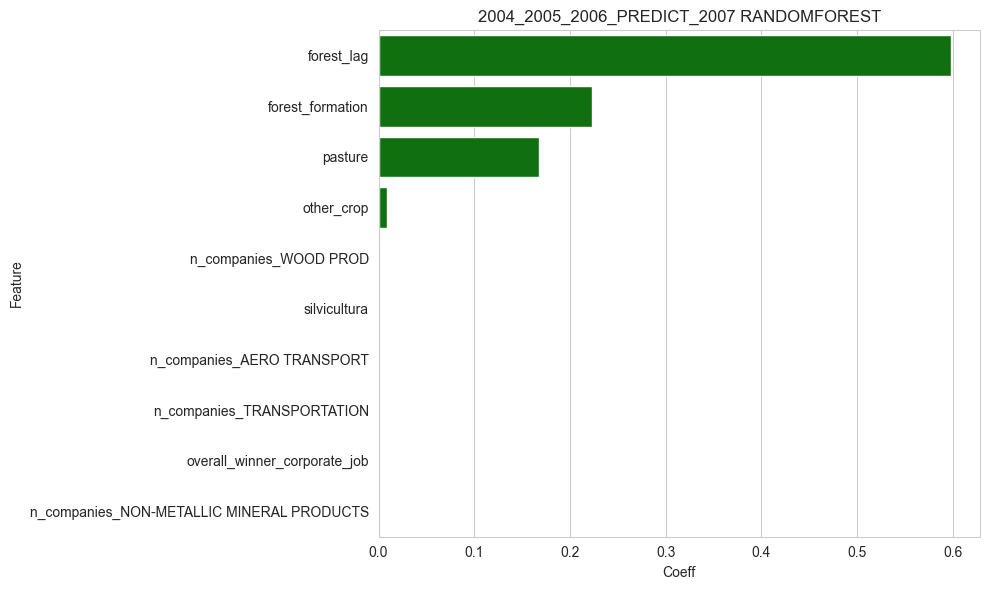

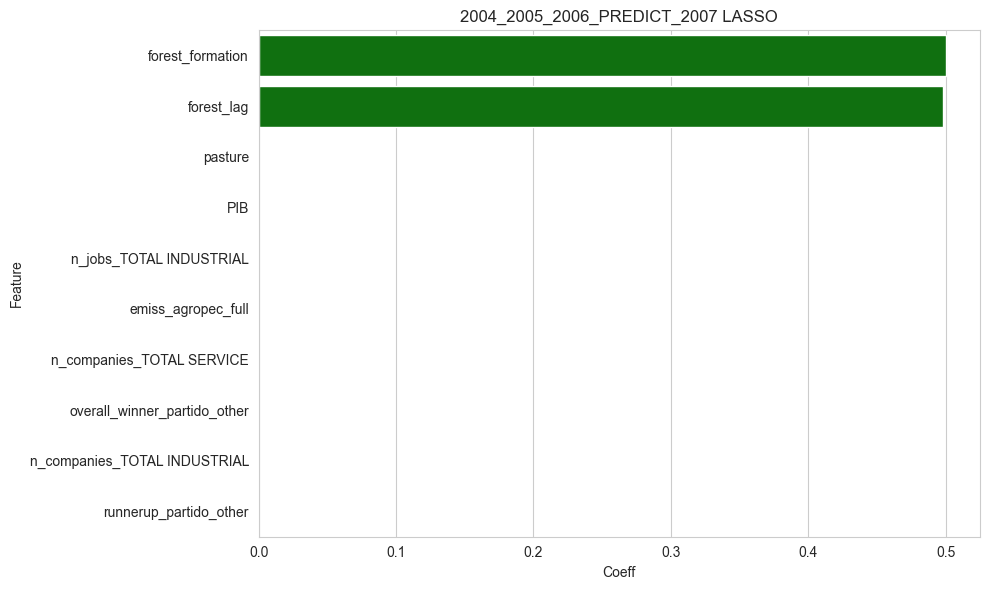

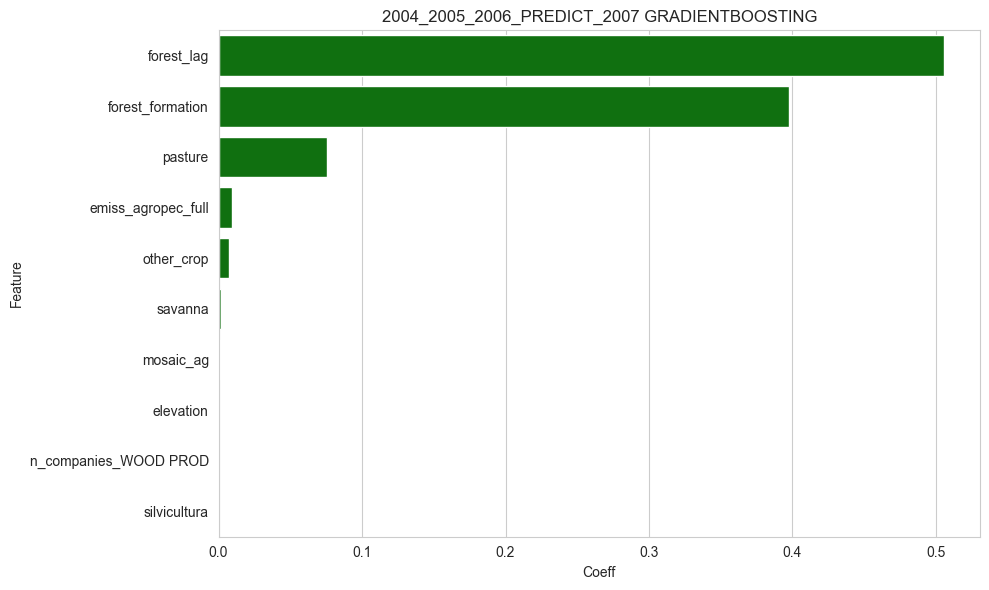

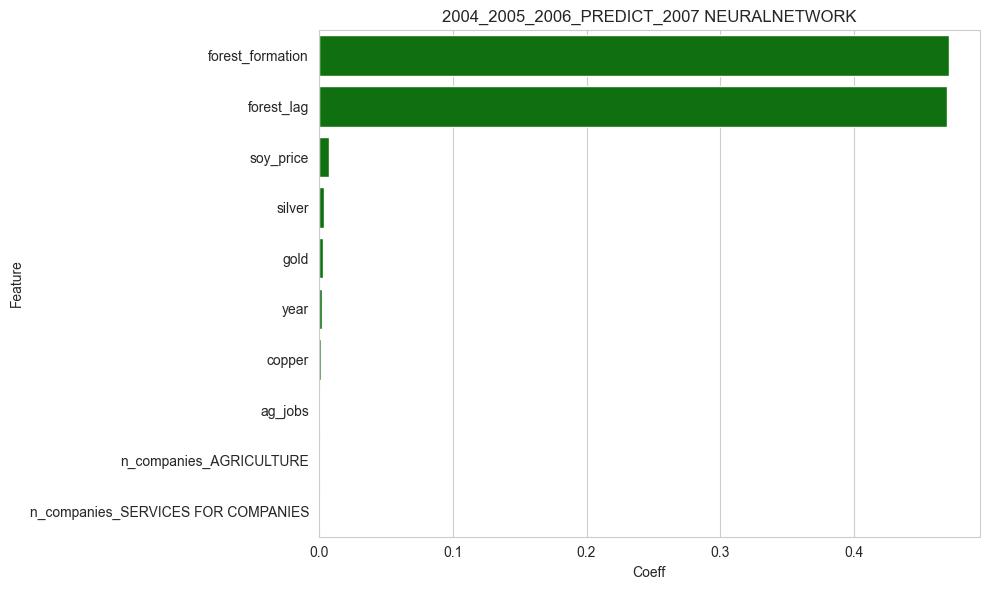

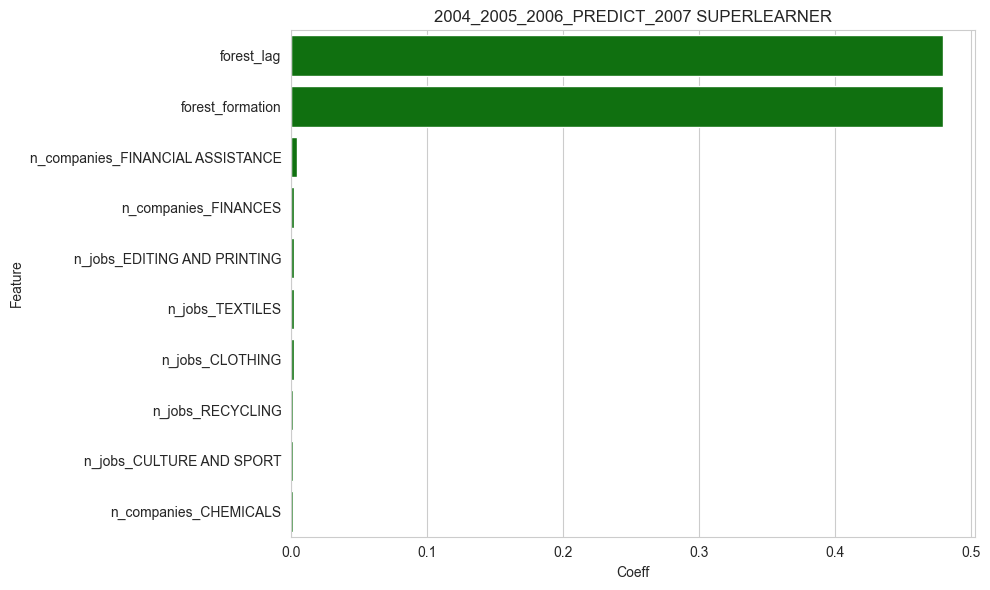

In [66]:
#for method in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner']:
for method in ['randomforest', 'lasso', 'gradientboosting', 'neuralnetwork', 'superlearner']:
        plot_feature_importance(FILE_PATH, FOLDER_NAME, method, use_abs = True)

In [76]:
def plot_feature_importance(FILE_PATH, FOLDER_NAME, method, SHOW = True, INCLUDE_FOREST = True, use_abs = True):
    file_path = FILE_PATH + 'FeatureImportance/' + method + '.csv'

    df = pd.read_csv(file_path, index_col=0)
    file_path_save = FILE_PATH + 'FeatureImportance/' + 'features_' + method

    if not INCLUDE_FOREST:
        df = df[~df.Feature.isin(['forest_lag', 'forest_formation'])]
        file_path_save = FILE_PATH + 'FeatureImportance/' + 'features_exclude_forest_vars_' + method

    abs_sum = df['Coeff'].abs().sum()
    df['Coeff'] = df['Coeff'] / abs_sum

    coeff_values = df['Coeff'].head(10)
    feature_labels = df['Feature'].head(10)

    if abs:
        coeff_values = (abs(coeff_values))

    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coeff_values, y=feature_labels, color='green')

    # Set plot title and labels
    plt.title(FOLDER_NAME + ' ' + method.upper() )
    #plt.xlabel('Abs')
    #plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(file_path_save)
    if SHOW: plt.show()

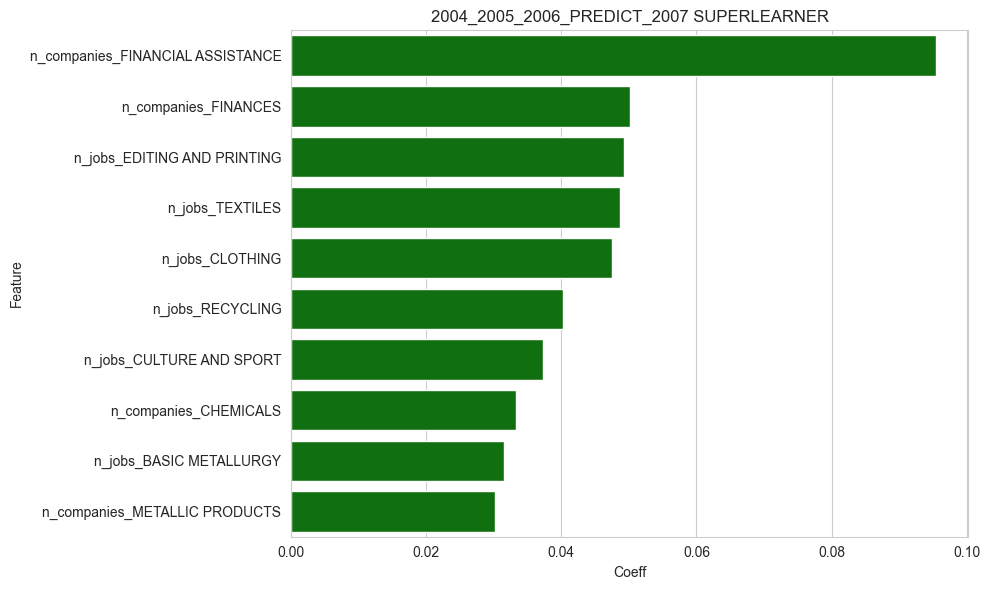

In [78]:
plot_feature_importance(FILE_PATH, FOLDER_NAME, method, SHOW = True, INCLUDE_FOREST = False, use_abs = True)

In [71]:
df.head()

,Feature,Coeff
203,forest_lag,-0.479329
187,forest_formation,0.479158
37,n_companies_FINANCIAL ASSISTANCE,-0.003964
45,n_companies_FINANCES,0.002084
94,n_jobs_EDITING AND PRINTING,0.002048


,Feature,Coeff
37,n_companies_FINANCIAL ASSISTANCE,-0.003964
45,n_companies_FINANCES,0.002084
94,n_jobs_EDITING AND PRINTING,0.002048
127,n_jobs_TEXTILES,0.002019
116,n_jobs_CLOTHING,0.001973
...,...,...
198,rice,0.000000
161,term_limited_seat,0.000000
200,coffee,0.000000
201,citrus,0.000000
